In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from pathlib import Path

import textstat
import nltk
from collections import Counter
from language_tool_python import LanguageTool

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

In [2]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

### Load Data

In [6]:
local_dir = Path(os.getcwd())
kaggle_df = '/kaggle/input/'

In [23]:
train_df = pd.read_csv(local_dir / 'commonlit-evaluate-student-summaries' / 'summaries_train.csv')
train_promts_df = pd.read_csv(local_dir / 'commonlit-evaluate-student-summaries' / 'prompts_train.csv')

# Create Features

In [24]:
def create_text_features(df):
    # Define the transition phrases
    transition_phrases_dict = {
        'To Add': ['and', 'again', 'and then', 'besides', 'equally important', 'finally', 'further', 'furthermore', 'nor', 'too', 'next', 'lastly', 'what\'s more', 'moreover', 'in addition', 'first', 'second', 'etc.'],
        'To Compare': ['whereas', 'but', 'yet', 'on the other hand', 'however', 'nevertheless', 'on the contrary', 'by comparison', 'where', 'compared to', 'up against', 'balanced against', 'vis a vis', 'but', 'although', 'conversely', 'meanwhile', 'after all', 'in contrast', 'although this may be true'],
        'To Prove': ['because', 'for', 'since', 'for the same reason', 'obviously', 'evidently', 'furthermore', 'moreover', 'besides', 'indeed', 'in fact', 'in addition', 'in any case', 'that is'],
        'To Show Exception': ['yet', 'still', 'however', 'nevertheless', 'in spite of', 'despite', 'of course', 'once in a while', 'sometimes'],
        'To Show Time': ['immediately', 'thereafter', 'soon', 'after a few hours', 'finally', 'then', 'later', 'previously', 'formerly', 'first', 'second', 'etc.', 'next', 'and then'],
        'To Repeat': ['in brief', 'as I have said', 'as I have noted', 'as has been noted'],
        'To Emphasize': ['definitely', 'extremely', 'obviously', 'in fact', 'indeed', 'in any case', 'absolutely', 'positively', 'naturally', 'surprisingly', 'always', 'forever', 'perennially', 'eternally', 'never', 'emphatically', 'unquestionably', 'without a doubt', 'certainly', 'undeniably', 'without reservation'],
        'To Show Sequence': ['first', 'second', 'third', 'and so forth', 'next', 'then', 'following this', 'at this time', 'now', 'at this point', 'after', 'afterward', 'subsequently', 'finally', 'consequently', 'previously', 'before this', 'simultaneously', 'concurrently', 'thus', 'therefore', 'hence', 'next', 'and then', 'soon'],
        'To Give an Example': ['for example', 'for instance', 'in this case', 'in another case', 'on this occasion', 'in this situation', 'take the case of', 'to demonstrate', 'to illustrate', 'as an illustration'],
        'To Summarize or Conclude': ['in brief', 'on the whole', 'summing up', 'to conclude', 'in conclusion', 'as I have shown', 'as I have said', 'hence', 'therefore', 'accordingly', 'thus', 'as a result', 'consequently']
    }
    
    # Precompile the regular expressions
    transition_phrases_dict = {
        name: [re.compile(r'\b' + re.escape(phrase) + r'\b') for phrase in phrases] for name, phrases in transition_phrases_dict.items()
    }

    for i, row in df.iterrows():
        # Tokenize the text
        text_words = nltk.word_tokenize(row['text'].lower())
        text_words = [word for word in text_words if word.isalpha()]
        text_sentences = nltk.sent_tokenize(row['text'])

        # Compute word count statistics
        word_counts = Counter(text_words)
        
        # Calculate the length metrics
        length_metrics = {
            'Text Length': len(row['text']),
            'Text Word Count': len(text_words),
            'Text Sentance Count': len(text_sentences),
            'Words Over 6': len([word for word in text_words if len(word) > 6]),
            'Words Over 8': len([word for word in text_words if len(word) > 8]),
            'Words Over 10': len([word for word in text_words if len(word) > 10]),
            'Unique Words': len(np.unique(text_words))
        }
        
        # Calculate the ratios
        ratio_metrics = {
            'Word Count to Length Ratio': length_metrics['Text Word Count'] / length_metrics['Text Length'],
            'Word Count to Length Ratio': length_metrics['Unique Words'] / length_metrics['Text Length'],
            'Unique Word Density': length_metrics['Unique Words'] / length_metrics['Text Word Count'],
            'Words Per Sentance': length_metrics['Text Word Count'] / length_metrics['Text Sentance Count'],
            'Average Sentance Legth': length_metrics['Text Length'] / length_metrics['Text Sentance Count'],
            'Words Over 6 Ratio': length_metrics['Words Over 6'] / length_metrics['Text Word Count'],
            'Words Over 8 Ratio': length_metrics['Words Over 8'] / length_metrics['Text Word Count'],
            'Words Over 10 Ratio': length_metrics['Words Over 10'] / length_metrics['Text Word Count'],
        }
        
        # Calculate the readability metrics
        readability_metrics = {
            'Flesch Reading Ease': textstat.flesch_reading_ease(row['text']),
            'Flesch Kincaid Grade': textstat.flesch_kincaid_grade(row['text']),
            'Smog Index': textstat.smog_index(row['text']),
            'Coleman Liau Index': textstat.coleman_liau_index(row['text']),
            'Automated Readability Index': textstat.automated_readability_index(row['text']),
            'Dale Chall Readability Score': textstat.dale_chall_readability_score(row['text']),
            'Difficult Words': textstat.difficult_words(row['text']),
            'Linsear Write Formula': textstat.linsear_write_formula(row['text']),
            'Gunning Fog': textstat.gunning_fog(row['text']),
            'Text Standard': textstat.text_standard(row['text'], float_output = True),
            'Fernandez Huerta': textstat.fernandez_huerta(row['text']),
            'Szigriszt Pazos': textstat.szigriszt_pazos(row['text']),
            'Gutierrez Polini': textstat.gutierrez_polini(row['text']),
            'Crawford': textstat.crawford(row['text']),
            'Gulpease Index': textstat.gulpease_index(row['text']),
            'Osman': textstat.osman(row['text']),
        }

        # Initialize the dictionary to store the counts of transition phrases
        transition_phrases_counts = {name + ' Transition': 0 for name in transition_phrases_dict}

        # Count the occurrences of each transition phrase
        for name, patterns in transition_phrases_dict.items():
            for pattern in patterns:
                transition_phrases_counts[name + ' Transition'] += len(pattern.findall(row['text'].lower()))
        

        # Calculate the sum of transition phrases and unique transitions
        transition_phrases_counts['Transitions Sum'] = sum(transition_phrases_counts.values())
        transition_phrases_counts['Unique Transitions'] = len([value for value in transition_phrases_counts.values() if value > 0]) - 1
        
        # Add the new metrics to the DataFrame
        for metric_name, metric_value in {**length_metrics, **ratio_metrics, **readability_metrics, **transition_phrases_counts}.items():
            df.at[i, metric_name] = metric_value
            
    return df


In [30]:
def create_grammar_features(df):
    grammar_tool = LanguageTool('en-US')
    # Pre-fill DataFrame
    grammar_cols = [
        'TYPOS', 'TYPOGRAPHY', 'CASING', 'PUNCTUATION', 'GRAMMAR',
        'REDUNDANCY', 'STYLE', 'CONFUSED_WORDS', 'OTHER',
        'TOTAL_ERRORS', 'MIN_ERROR_LOCATION', 'MAX_ERROR_LOCATION', 'AVERAGE_ERROR_LOCATION'
    ]
    df_len = len(df)
    df_width = len(grammar_cols)
    grammar_df = pd.DataFrame(
        data = np.zeros((df_len, df_width), dtype=float),
        columns = grammar_cols,
        index = df.index
    )
    
    for idx, text in df['text'].items():
        matches = grammar_tool.check(text)
        error_locations = []
        grammar_df.loc[idx, 'TOTAL_ERRORS'] = len(matches)
        for match in matches:
            if match.category in grammar_cols:
                grammar_df.loc[idx, match.category] += 1
            else:
                grammar_df.loc[idx, 'OTHER'] += 1
            
            error_locations.append(match.offset)
        
        if len(error_locations) > 0:
            grammar_df.at[idx, 'MIN_ERROR_LOCATION'] = min(error_locations)
            grammar_df.at[idx, 'MAX_ERROR_LOCATION'] = max(error_locations)
            grammar_df.at[idx, 'AVERAGE_ERROR_LOCATION'] = np.mean(error_locations)
    
    # Beautify column names
    grammar_df.columns = grammar_df.columns.str.title().str.replace('_', ' ')
    return pd.concat([df, grammar_df], axis = 1)

In [26]:
def create_grammar_features(df):
    grammar_tool = LanguageTool('en-US')
    grammar_df_cols = [
        'TYPOS', 'TYPOGRAPHY', 'CASING', 'PUNCTUATION', 'GRAMMAR', 'REDUNDANCY', 'STYLE', 'CONFUSED_WORDS', 'OTHER', 'TOTAL_ERRORS', 
        'MIN_ERROR_LOCATION', 'MAX_ERROR_LOCATION', 'AVERAGE_ERROR_LOCATION'
    ]
    grammar_features_df = pd.DataFrame(columns = grammar_df_cols)
    
    for i, row in df.iterrows():
        new_row = pd.DataFrame(
            columns = grammar_df_cols,
            data = np.zeros((1, len(grammar_df_cols))).astype(float),
            index = [i]
        )
        text = row['text']
        matches = grammar_tool.check(text)
        new_row['TOTAL_ERRORS'] = len(matches)
        
        error_locations = []
        for match in matches:
            if match.category in new_row.columns:
                new_row[match.category] += 1
                error_locations.append(match.offset)
            else:
                new_row['OTHER'] += 1
                error_locations.append(match.offset)
        
        if len(error_locations) == 0:
            pass
        
        else:
            new_row['MIN_ERROR_LOCATION'] = min(error_locations)
            new_row['MAX_ERROR_LOCATION'] = max(error_locations)
            new_row['AVERAGE_ERROR_LOCATION'] = np.mean(error_locations)
        
        grammar_features_df = pd.concat([grammar_features_df, new_row], ignore_index = False)
        
    # capitalize columns and change '_' with ' '
    grammar_features_df.columns = grammar_features_df.columns.str.title().str.replace('_', ' ')
    df = pd.concat([df, grammar_features_df], axis = 1)
    
    return df

In [31]:
train_df = create_text_features(train_df)
train_df = create_grammar_features(train_df)

Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
Processed 100 of 7165 rows
P

# Modeling

In [48]:
train_df

,student_id,prompt_id,text,content,wording,Text Length,Text Word Count,Text Sentance Count,Words Over 6,Words Over 8,...,Punctuation,Grammar,Redundancy,Style,Confused Words,Other,Total Errors,Min Error Location,Max Error Location,Average Error Location
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,346.0,61.0,4.0,12.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,22.0,263.0,165.000000
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,244.0,52.0,2.0,3.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,3.0,64.0,177.0,109.666667
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,1370.0,232.0,12.0,46.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,256.0,1282.0,769.000000
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,157.0,21.0,2.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,54.0,96.0,79.000000
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,1225.0,199.0,14.0,50.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,15.0,24.0,1121.0,537.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538,357.0,66.0,2.0,7.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171,255.0,42.0,3.0,9.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,200.0,247.0,223.500000
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603,272.0,46.0,2.0,6.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,266.0,130.416667
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128,294.0,59.0,3.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,9.0,9.000000


In [37]:
train_promts_df

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [39]:
train_promts_df.loc[0, 'prompt_title']

'On Tragedy'

In [36]:
train_promts_df.loc[0, 'prompt_question']

'Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.'

In [38]:
train_promts_df.loc[0, 'prompt_text']

'Chapter 13 \r\nAs the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. \r\nA perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity or fear. Nor, again, should the downfall of the utter villain be exhibited. A plot of this kind would, 

In [115]:
X_train = train_df.drop(['student_id', 'prompt_id', 'text', 'content', 'wording'], axis = 1)
y_train = train_df['content']

In [116]:
xtree = RandomForestRegressor(random_state = 42)

parameters = {
    'n_estimators': [100]
}

grid_obj = GridSearchCV(xtree, parameters, scoring = 'neg_root_mean_squared_error', cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)
xtree = grid_obj.best_estimator_
xtree.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [117]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.394241,0.050656,0.027461,0.000484,100,{'n_estimators': 100},-0.496178,-0.500011,-0.480551,-0.476321,-0.496302,-0.489873,0.009533,1


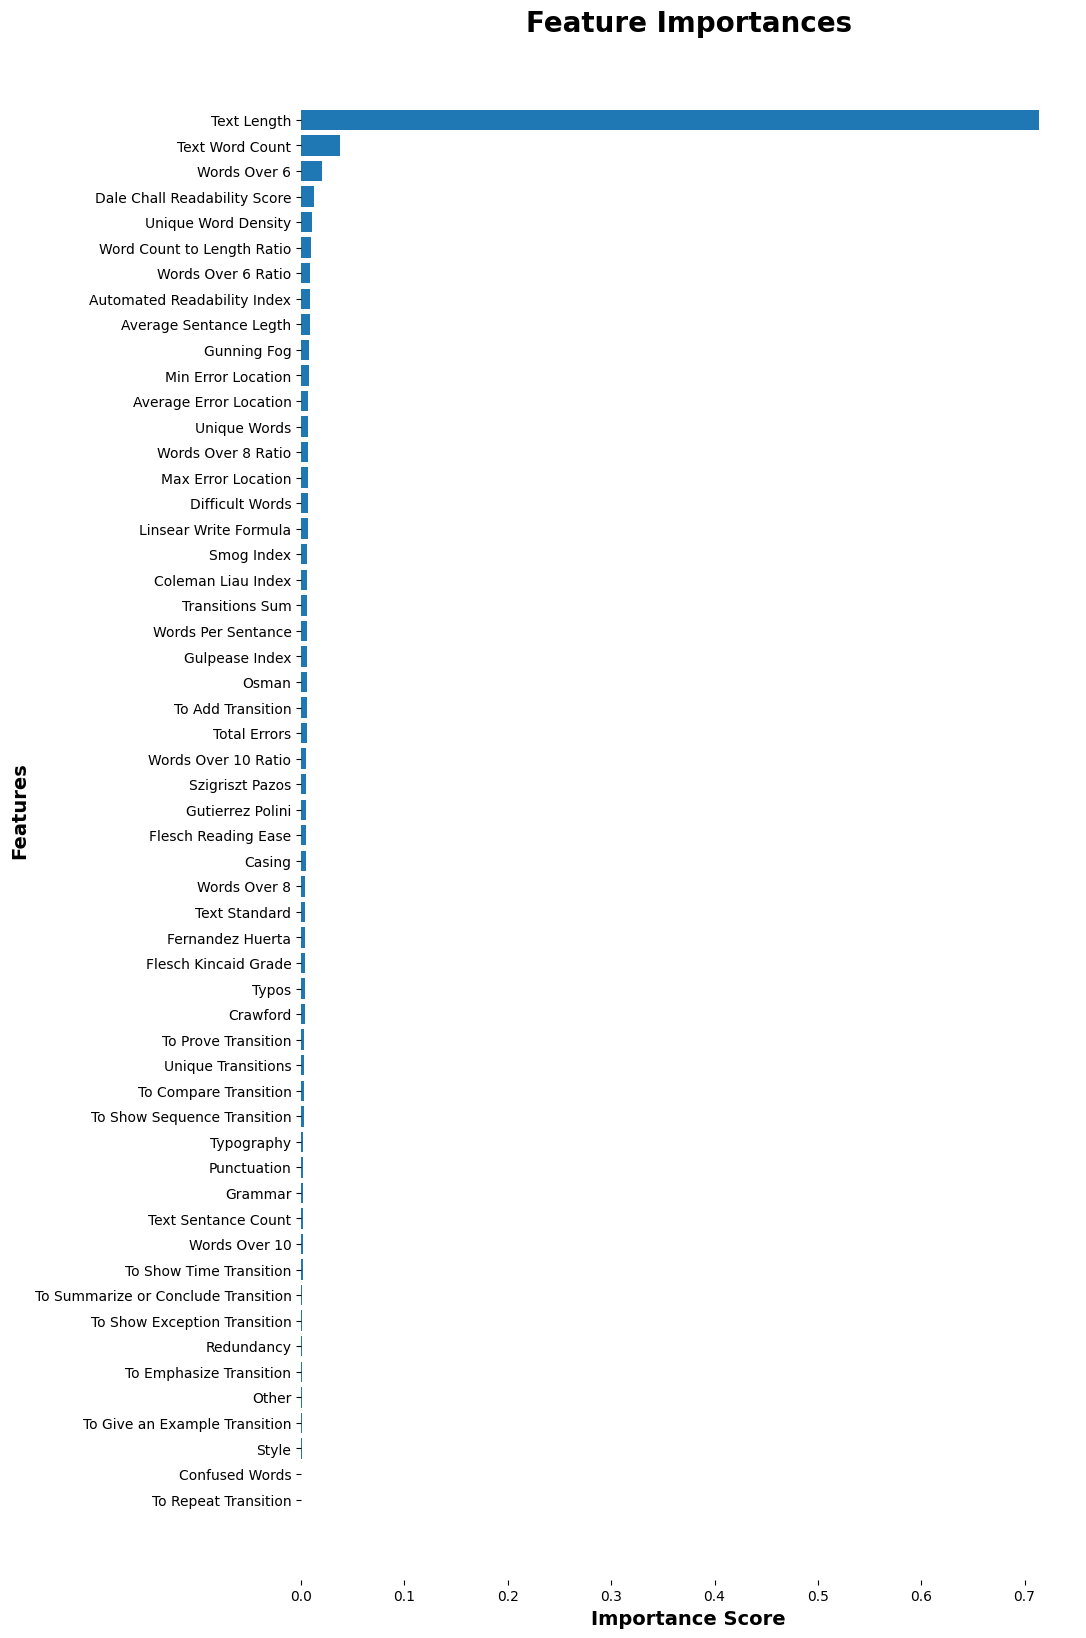

In [118]:
importances = pd.Series(xtree.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()